In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import time
from tqdm import tqdm
import json
from contextlib import redirect_stdout
from autorank import autorank, plot_stats
import scikit_posthocs as sp
import io
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
import hashlib
from collections import defaultdict
import itertools

In [6]:
def load_json_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)
    
class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        try:
            return super().default(obj)
        except TypeError:
            pass
        if hasattr(obj, '__dict__'):
            return obj.__dict__
        elif hasattr(obj, '__str__'):
            return str(obj)
        else:
            return f"<non-serializable: {type(obj).__name__}>"

def save_json(data, path, indent=4):
    with open(path, "w") as f:
        json.dump(data, f, indent=indent, cls=CustomJSONEncoder)

def hash_dict(d):
    dict_str = json.dumps(d, sort_keys=True)
    return hashlib.sha256(dict_str.encode('utf-8')).hexdigest()

def avg_results(data, n_folds=10):
    out = {}
    for key in list(data.keys()):
        accs = []
        f1s = []
        for i in range(n_folds):
            temp = data[key]['results'][f'fold_{i}']
            accs.append(temp['acc'])
            f1s.append(temp['f1'])
        out[key] =  {
            'mean_acc': float(np.mean(accs)),
            'std_acc': float(np.std(accs)),
            'mean_f1': float(np.mean(f1s)),
            'std_f1': float(np.std(f1s))
        }
    return out

def sort_results(full_data, key, show=False, top_n=10):
    avg_data = avg_results(full_data)
    out = sorted(avg_data.keys(), key=lambda k: avg_data[k][f'mean_{key}'], reverse=True)
    if show == True:
        for r in out[:top_n]:
            print(f"ID: {r} Parameters: {full_data[r]['params']} -> {key}: {avg_data[r]['mean_' + key]} ± {avg_data[r]['std_' + key]}")
    return out

## Load relevant results

In [8]:
stack = load_json_file('../../results/hetero/stack_results.json')
rf = load_json_file('../../results/rf/rf_results.json')

In [15]:
def create_df(rf, stack, top_n=3, metric='acc', n_folds=10):
    out = []
    rf_keys = sort_results(rf, metric, show=False)[:top_n]
    stack_keys = sort_results(stack, metric, show=False)[:top_n]
    count = 1
    for k in rf_keys:
        temp = {}
        temp['id'] = f'RF_{count}'
        for i in range(n_folds):
            temp[f'fold_{i}'] = rf[k]['results'][f'fold_{i}'][metric]
        out.append(temp)
        count+=1
    count = 1
    for k in stack_keys:
        temp = {}
        temp['id'] = f'Stack_{count}'
        for i in range(n_folds):
            temp[f'fold_{i}'] = stack[k]['results'][f'fold_{i}'][metric]
        out.append(temp)
        count+=1
    out = pd.DataFrame(out)
    out = out.set_index('id')
    return out


In [41]:
create_df(rf, stack, metric='f1')

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9
id,,,,,,,,,,
RF_1,0.976744,0.954545,0.952381,0.975610,0.952381,0.97561,0.909091,0.950000,0.952381,0.950000
RF_2,0.976744,0.954545,0.952381,0.975610,0.952381,0.97561,0.909091,0.950000,0.952381,0.950000
RF_3,0.976744,0.954545,0.952381,0.975610,0.952381,0.97561,0.909091,0.950000,0.952381,0.950000
Stack_1,0.976744,0.930233,0.933333,0.954545,0.952381,0.95000,0.976744,0.926829,1.000000,0.926829
Stack_2,0.976744,0.930233,0.933333,0.954545,0.952381,0.95000,0.976744,0.926829,1.000000,0.926829
Stack_3,0.976744,0.930233,0.933333,0.954545,0.952381,0.95000,0.976744,0.950000,1.000000,0.900000


## Perform stat tests

In [39]:
def stat_tests(rf, stack, metric, signifigance_level = 0.05):

    df = create_df(rf, stack, metric=metric).T

    map = {
        'acc': 'accuracy',
        'f1': 'F1-score', 
        }

    posthoc_results = sp.posthoc_nemenyi_friedman(df)
    plt.title(f'Signifigance Plot between best KNN and DT models based on {map[metric]}')
    sp.sign_plot(posthoc_results)
    plt.title('p-value')
    plt.show

    f = io.StringIO()
    with redirect_stdout(f):
        results = autorank(df, alpha=signifigance_level, verbose=False, force_mode='nonparametric', order='ascending')
    plot_stats(results, allow_insignificant=True)
    plt.title(f'Critical Distance plot based on {map[metric]}')
    plt.show()

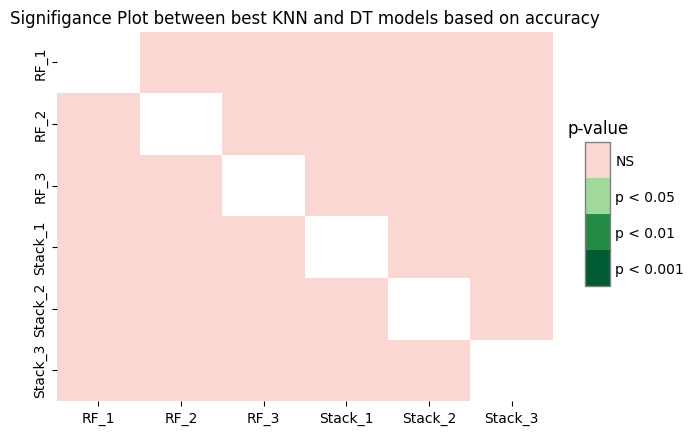

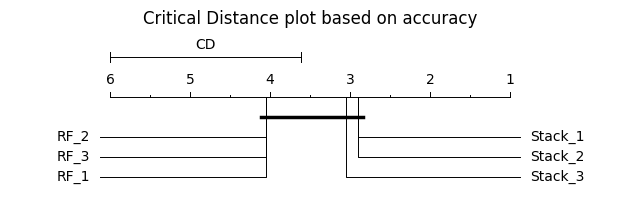

In [34]:
stat_tests(rf, stack, 'acc', signifigance_level=0.05)

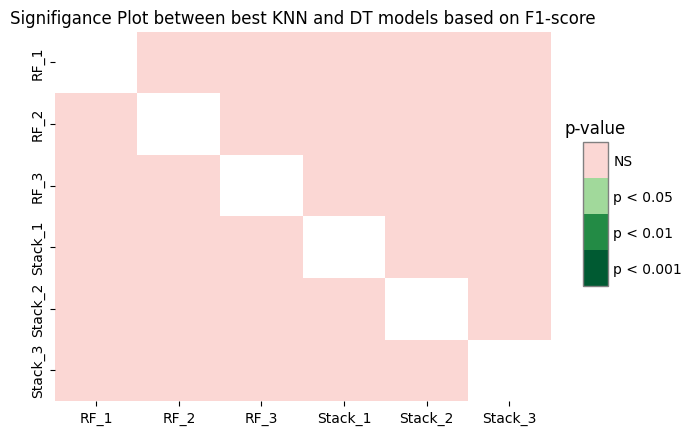

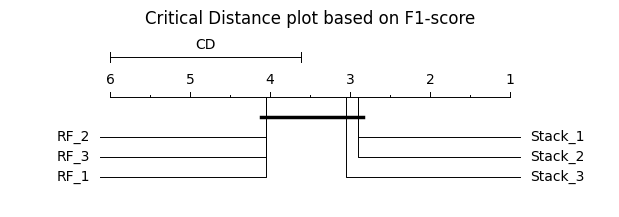

In [40]:
stat_tests(rf, stack, 'f1', signifigance_level=0.05)